# Uplift Curves with TMLE Example

This notebook demonstrates the issue of using uplift curves without knowing true treatment effect and how to solve it by using TMLE as a proxy of the true treatment effect.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
base_path = os.path.abspath("../")
os.chdir(base_path)

In [3]:
import logging
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import sys
import warnings
warnings.simplefilter("ignore", UserWarning)

from lightgbm import LGBMRegressor

In [4]:
import causalml

from causalml.dataset import synthetic_data
from causalml.inference.meta import BaseXRegressor, TMLELearner
from causalml.metrics.visualize import *

import importlib
print(importlib.metadata.version('causalml') )

/Users/jeong/dev/causalml/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to import duecredit due to No module named 'duecredit'


0.15.5.dev0


In [5]:
logger = logging.getLogger('causalml')
logger.setLevel(logging.DEBUG)
plt.style.use('fivethirtyeight')

## Generating Synthetic Data

In [6]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=1000000, p=10, sigma=5.)

In [7]:
X_train, X_test, y_train, y_test, e_train, e_test, treatment_train, treatment_test, tau_train, tau_test, b_train, b_test = train_test_split(X, y, e, treatment, tau, b, test_size=0.5, random_state=42)

## Calculating Individual Treatment Effect (ITE/CATE)

In [8]:
# X Learner
learner_x = BaseXRegressor(learner=LGBMRegressor())
learner_x.fit(X=X_train, treatment=treatment_train, y=y_train)
cate_x_test = learner_x.predict(X=X_test, p=e_test, treatment=treatment_test).flatten()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 240810, number of used features: 10
[LightGBM] [Info] Start training from score 1.031908
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 259190, number of used features: 10
[LightGBM] [Info] Start training from score 1.918515
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

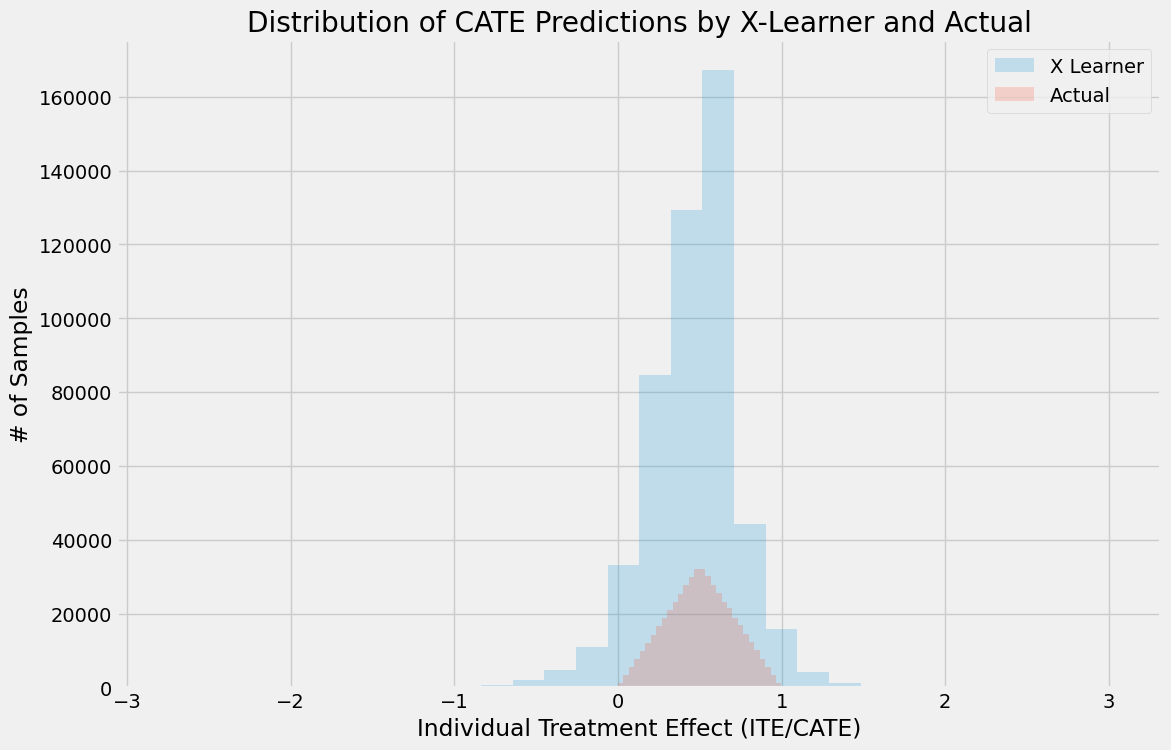

In [9]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_x_test, alpha=alpha, bins=bins, label='X Learner')
plt.hist(tau_test, alpha=alpha, bins=bins, label='Actual')

plt.title('Distribution of CATE Predictions by X-Learner and Actual')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

## Validating CATE without TMLE

In [10]:
df = pd.DataFrame({'y': y_test, 'w': treatment_test, 'tau': tau_test, 'X-Learner': cate_x_test, 'Actual': tau_test})

### Uplift Curve With Ground Truth

If true treatment effect is known as in simulations, the uplift curve of a model uses the cumulative sum of the treatment effect sorted by model's CATE estimate.

In the figure below, the uplift curve of X-learner shows positive lift close to the optimal lift by the ground truth.

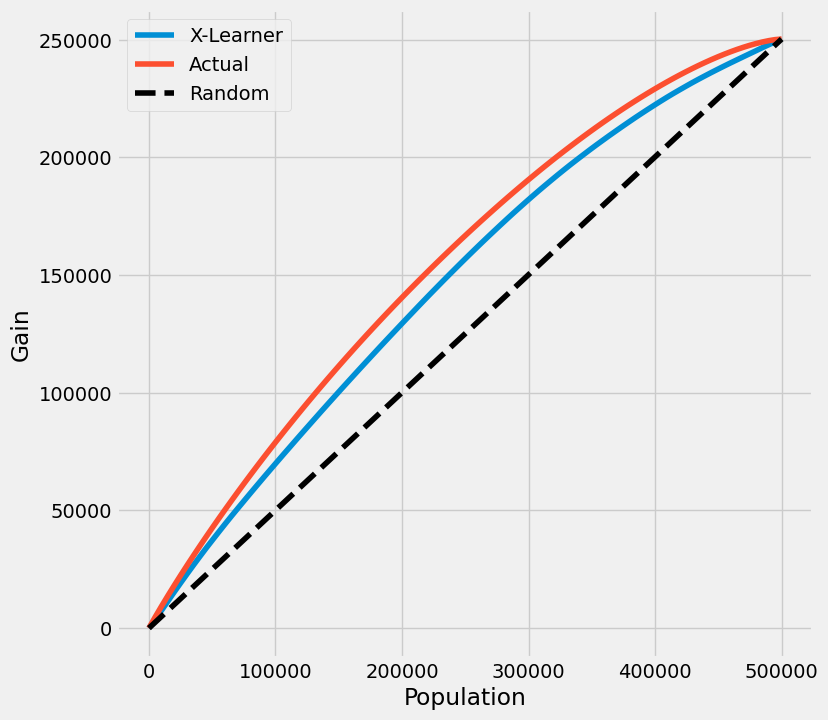

In [11]:
plot(df, outcome_col='y', treatment_col='w', treatment_effect_col='tau')

### Uplift Curve Without Ground Truth

If true treatment effect is unknown as in practice, the uplift curve of a model uses the cumulative mean difference of outcome in the treatment and control group sorted by model's CATE estimate.

In the figure below, the uplift curves of X-learner as well as the ground truth show no lift incorrectly.

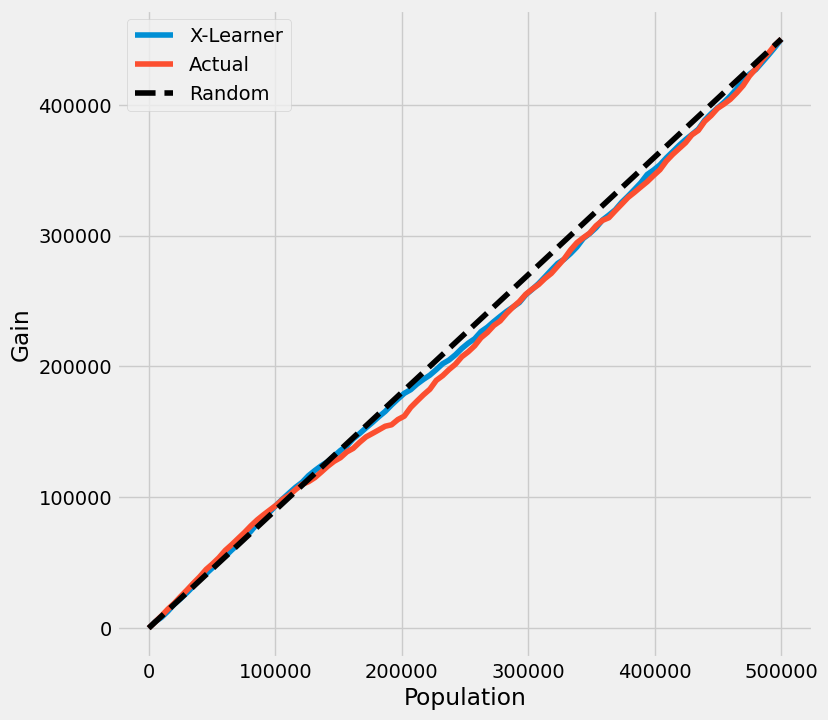

In [12]:
plot(df.drop('tau', axis=1), outcome_col='y', treatment_col='w')

## TMLE 

### Uplift Curve with TMLE as Ground Truth

By using TMLE as a proxy of the ground truth, the uplift curves of X-learner and the ground truth become close to the original using the ground truth.

In [13]:
n_fold = 5
kf = KFold(n_splits=n_fold)

In [14]:
df = pd.DataFrame({'y': y_test, 'w': treatment_test, 'p': e_test, 'X-Learner': cate_x_test, 'Actual': tau_test})

In [15]:
inference_cols = []
for i in range(X_test.shape[1]):
    col = 'col_' + str(i)
    df[col] = X_test[:,i]
    inference_cols.append(col)

In [16]:
df.head()

,y,w,p,X-Learner,Actual,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9
0,-1.172418,0,0.306314,0.292809,0.369913,0.564180,0.175646,0.811024,0.347398,0.873862,0.822687,0.615974,0.178150,0.320590,0.384264
1,0.289621,0,0.290396,0.296887,0.424024,0.717296,0.130751,0.927909,0.453772,0.300610,0.561574,0.599298,0.537041,0.616589,0.444704
2,-3.709188,1,0.873150,0.737726,0.595008,0.468088,0.721929,0.174398,0.190066,0.519165,0.880392,0.868682,0.606476,0.585635,0.697090
3,2.556804,1,0.900000,0.292399,0.711302,0.713268,0.709336,0.880897,0.246433,0.574616,0.004385,0.897898,0.122412,0.691561,0.089741
4,5.151192,1,0.761681,0.569939,0.854140,0.782163,0.926117,0.697098,0.133041,0.153903,0.190420,0.943172,0.004570,0.607202,0.386699


In [17]:
tmle_df = get_tmlegain(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                       n_segment=5, cv=kf, ci=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.502160
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.500492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

In [18]:
tmle_df

,X-Learner,Actual
0.0,0.000000,0.000000
0.2,0.129817,0.137608
0.4,0.245069,0.260248
0.6,0.342145,0.360499
0.8,0.416171,0.424499
1.0,0.464096,0.464096


#### Uplift Curve wihtout CI

Here we can directly use `plot_tmle()` function to generate the results and plot uplift curve

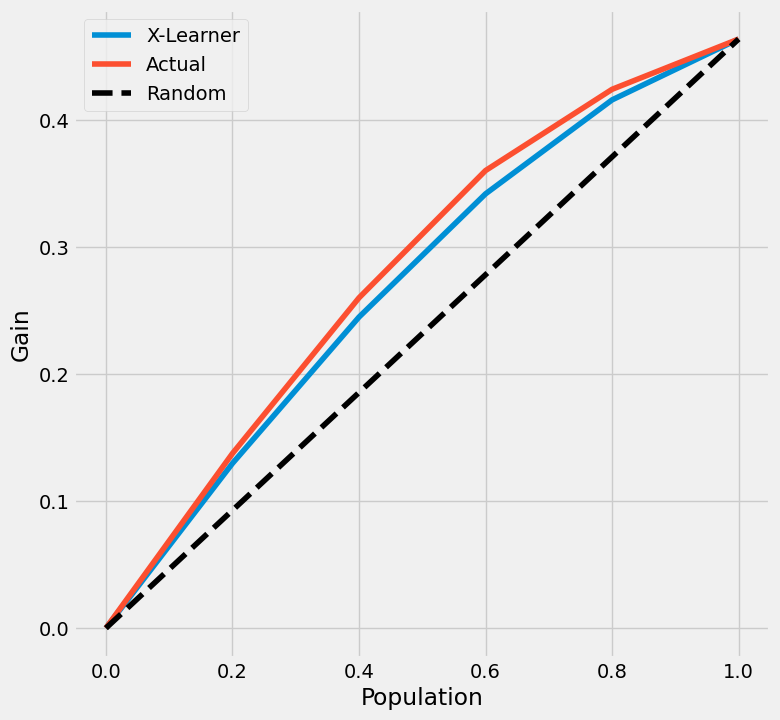

In [19]:
plot_tmlegain(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
              n_segment=5, cv=kf, ci=False)

We also provide the api call directly with `plot()` by input `kind='gain'` and `tmle=True`

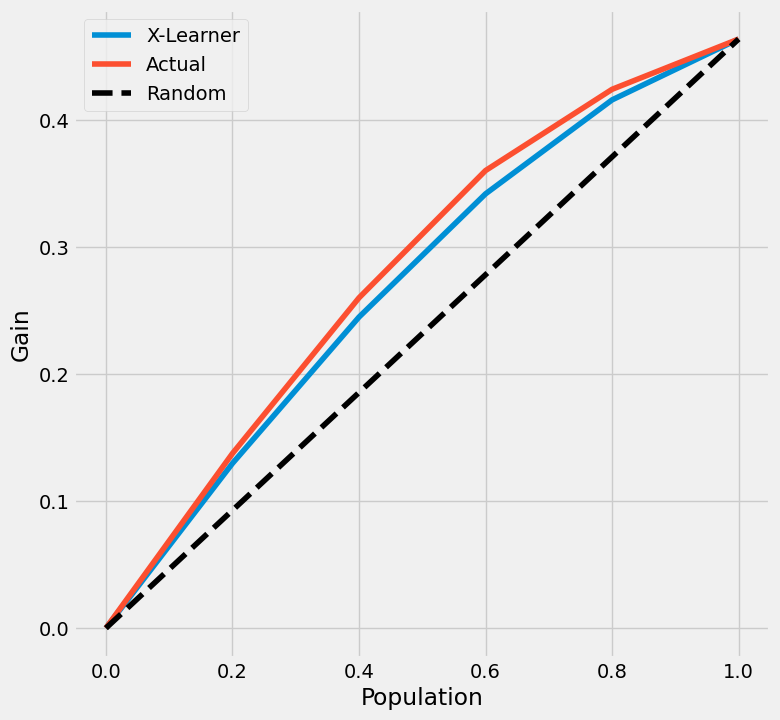

In [20]:
plot(df, kind='gain', tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, ci=False)

#### AUUC Score

In [21]:
auuc_score(df, tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
           n_segment=5, cv=kf, ci=False)

X-Learner    0.266217
Actual       0.274492
dtype: float64

#### Uplift Curve with CI

In [22]:
tmle_df = get_tmlegain(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                       n_segment=5, cv=kf, ci=True)

In [23]:
tmle_df

,X-Learner,Actual,X-Learner LB,Actual LB,X-Learner UB,Actual UB
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.2,0.129817,0.137608,0.112298,0.118507,0.147336,0.156709
0.4,0.245069,0.260248,0.210048,0.223065,0.280090,0.297431
0.6,0.342145,0.360499,0.291017,0.309211,0.393274,0.411787
0.8,0.416171,0.424499,0.348987,0.358126,0.483356,0.490873
1.0,0.464096,0.464096,0.425783,0.425783,0.502409,0.502409


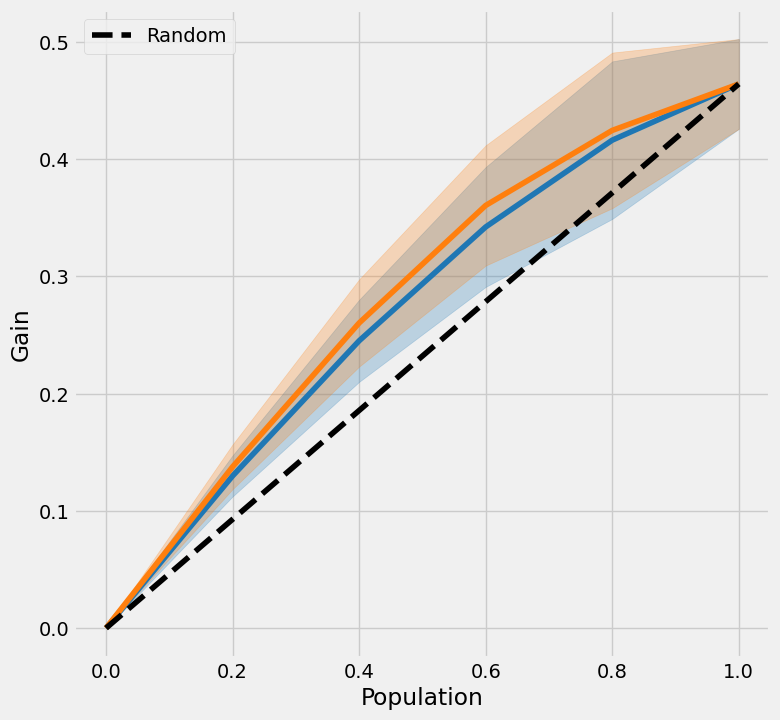

In [24]:
plot_tmlegain(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
              n_segment=5, cv=kf, ci=True)

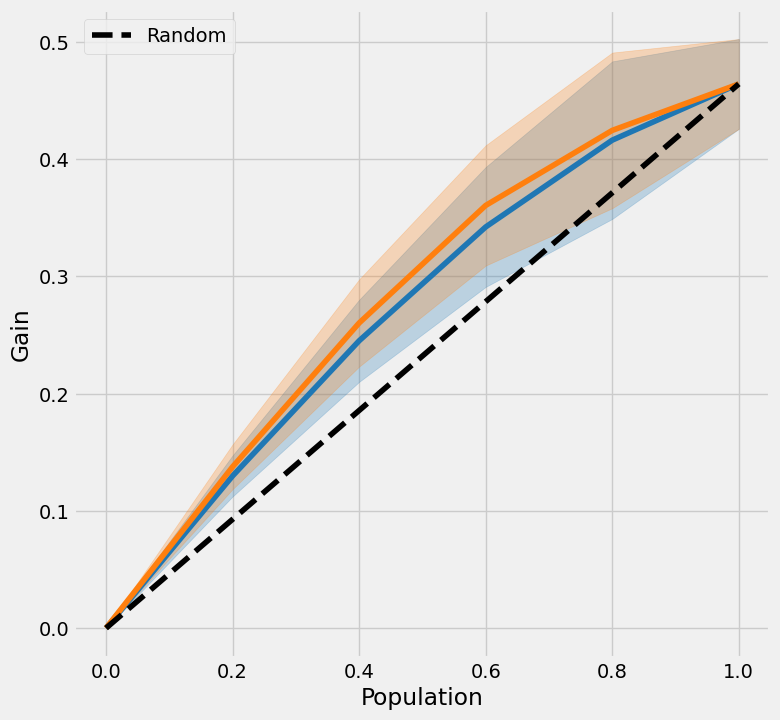

In [25]:
plot(df, kind='gain', tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, ci=True)

### Qini Curve with TMLE as Ground Truth

#### Qini Curve without CI

In [26]:
qini = get_tmleqini(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                    n_segment=5, cv=kf, ci=False)

In [27]:
qini

,X-Learner,Actual
0.0,0.000000,0.000000
100000.0,44988.697939,56195.170032
200000.0,86989.528719,106484.749293
300000.0,116979.294111,132366.559586
400000.0,130594.141768,142357.640896
500000.0,120742.005413,120742.005413


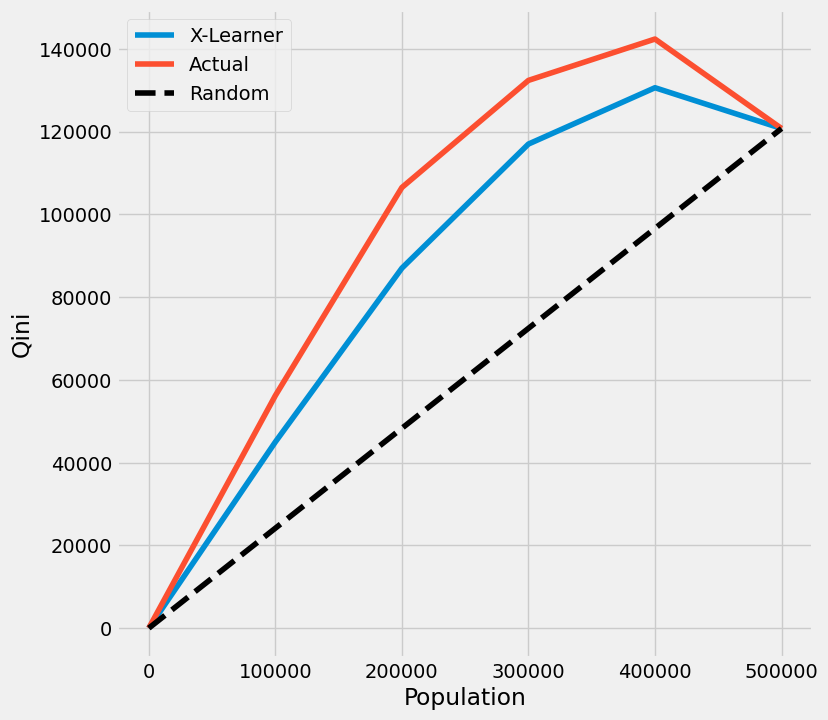

In [28]:
plot_tmleqini(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
              n_segment=5, cv=kf, ci=False)

We also provide the api call directly with `plot()` by input `kind='qini'` and `tmle=True`

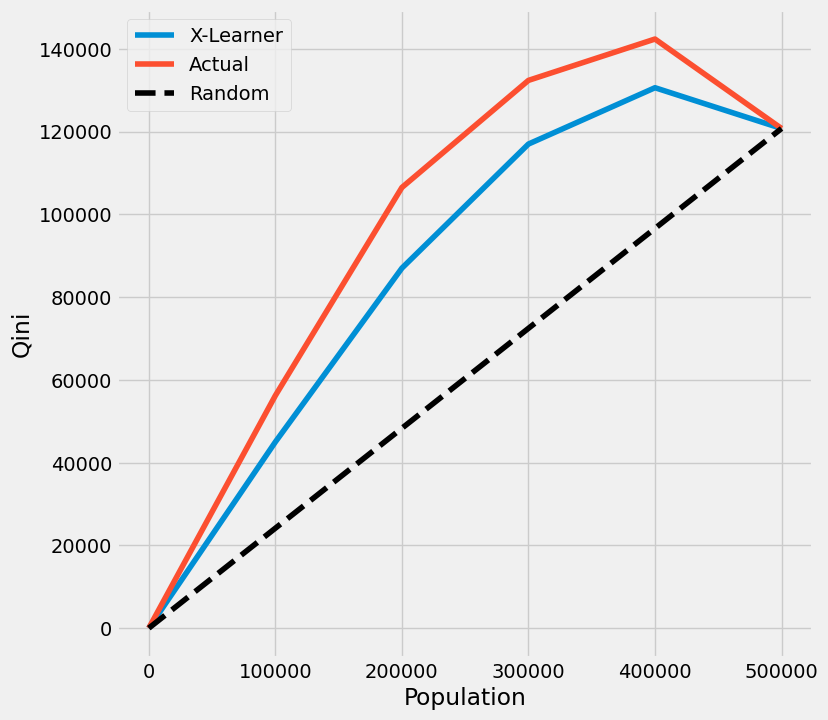

In [29]:
plot(df, kind='qini', tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, ci=False)

#### Qini Score

In [30]:
qini_score(df, tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
           n_segment=5, cv=kf, ci=False)

X-Learner    23011.275285
Actual       32653.351497
dtype: float64

#### Qini Curve with CI

In [31]:
qini = get_tmleqini(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                    n_segment=5, cv=kf, ci=True)

In [32]:
qini

,X-Learner,Actual,X-Learner LB,Actual LB,X-Learner UB,Actual UB
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
100000.0,44988.697939,56195.170032,38917.392834,48394.895995,51060.003044,63995.444069
200000.0,86989.528719,106484.749293,74540.043943,91269.597859,99439.013495,121699.900726
300000.0,116979.294111,132366.559586,99553.599324,113510.079995,134404.988898,151223.039177
400000.0,130594.141768,142357.640896,110215.540730,121146.165100,150972.742806,163569.116693
500000.0,120742.005413,120742.005413,120742.005413,120742.005413,120742.005413,120742.005413


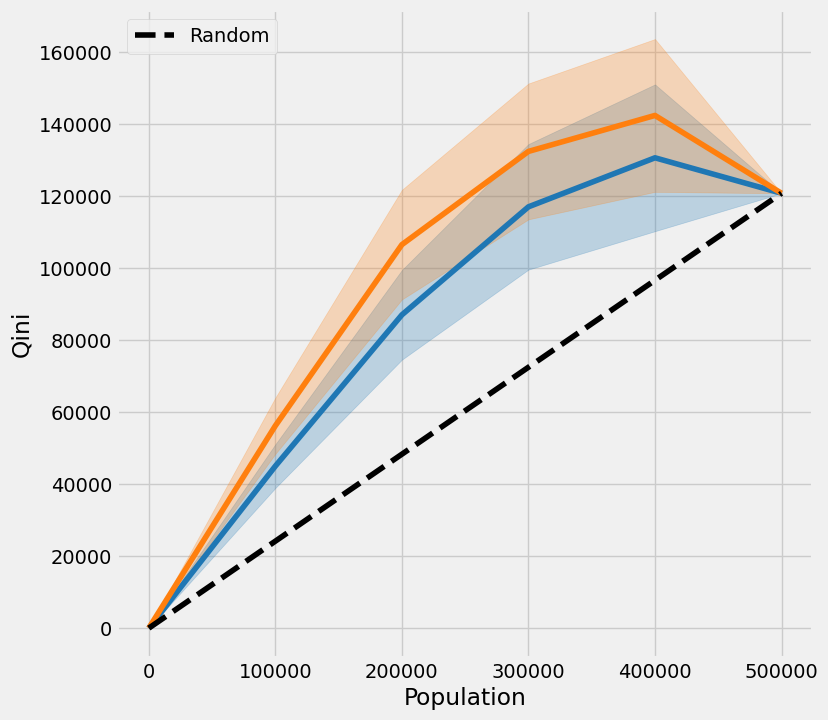

In [33]:
plot_tmleqini(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
              n_segment=5, cv=kf, ci=True)

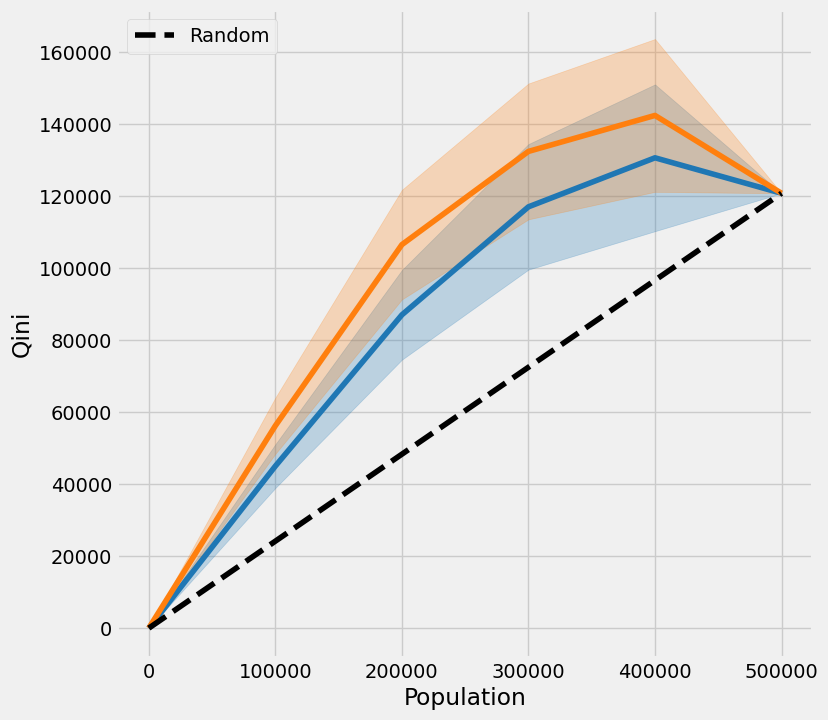

In [34]:
plot(df, kind='qini', tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, ci=True)